## [Hep.TrkX](https://indico.cern.ch/event/658267/contributions/2881175/attachments/1621912/2581064/Farrell_heptrkx_ctd2018.pdf)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
from tqdm import tqdm
from collections import namedtuple
from util import load_events, plot_event, create_graph_list, graph_generator
from gnn import GNN

In [3]:
events = load_events('toy_dataset.csv', chamber_id=None, start=0, end=1500)

Stations selected are:  [1 2 3 4 5 6]


In [4]:
graphs = create_graph_list(events)

  0%|          | 3/1500 [00:00<00:53, 28.01it/s]



Creating Graph List. This may take a while, please be patient 
Processing 1500 events 



100%|██████████| 1500/1500 [00:20<00:00, 72.91it/s]


In [5]:
X_train, y_train = graph_generator(graphs, start=0, end=1000)
X_test, y_test   = graph_generator(graphs, start=1000, end=1500)

100%|██████████| 500/500 [00:00<00:00, 13509.88it/s]


In [6]:
model = GNN(50)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=4)

200/200 [==============================] - 20s 99ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 5.9380e-04 - val_accuracy: 1.0000


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <a list of 6 Text major ticklabel objects>)

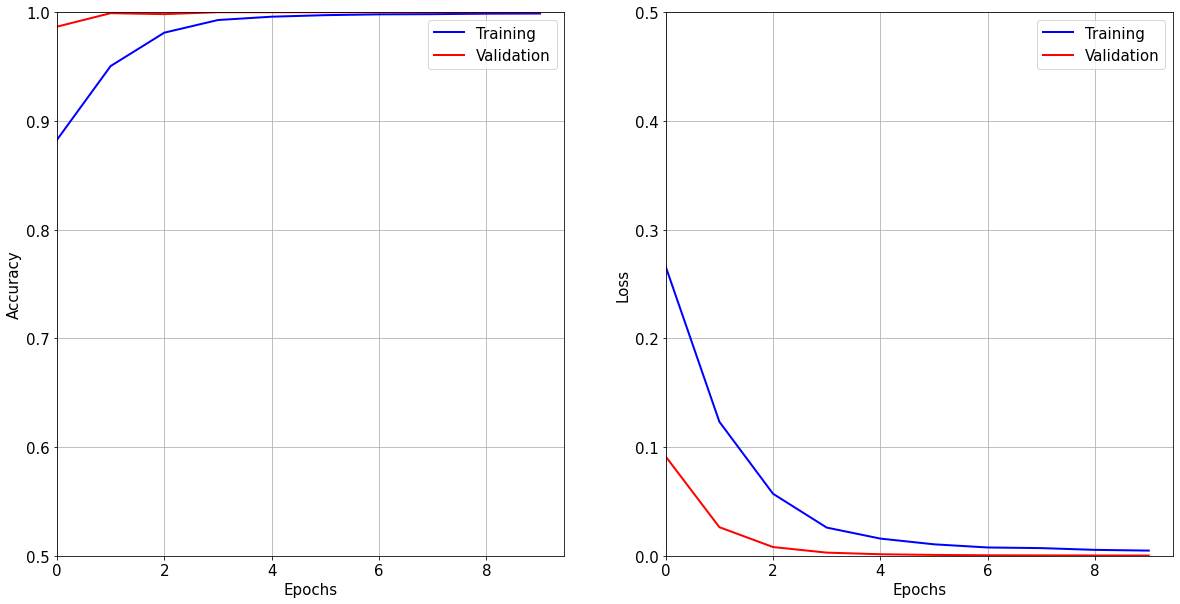

In [15]:
valid = history.history

fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(np.array(valid['accuracy']), label='Training',  color='blue', linewidth= 2)
plt.plot(np.array(valid['val_accuracy']), label='Validation',  color='red', linewidth= 2)
plt.xlim(0)
plt.ylim(0.5,1.00)
plt.grid(True)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(np.array(valid['loss']), label='Training',  color='blue', linewidth= 2)
plt.plot(np.array(valid['val_loss']), label='Validation',  color='red', linewidth= 2)
plt.xlim(0)
plt.ylim(0.0,0.5)
plt.grid(True)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [9]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 3s 162ms/step - loss: 0.0015 - accuracy: 1.0000


[0.0015453489031642675, 1.0]

### plot event graph

In [10]:
# get graph features
index = 401
G, df   = graphs[index], events[index]
X   = G.X.reshape(1,G.X.shape[0],G.X.shape[1]).astype(np.float32)
Ri  = G.Ri.reshape(1,G.Ri.shape[0],G.Ri.shape[1]).astype(np.float32)
Ro  = G.Ro.reshape(1,G.Ro.shape[0],G.Ro.shape[1]).astype(np.float32)
y   = G.y.astype(np.float32).flatten()
ids = G.hit_ids

In [11]:
ypred = model.predict([X, Ri, Ro]).flatten()

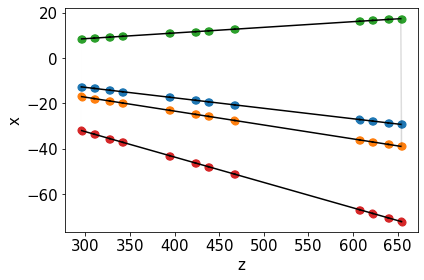

In [12]:
for tpid, pid, hit_ids in zip(y, ypred, ids):
    #if pid<0.5: continue
    p = df[df['hit_id'].isin(hit_ids)]
    plt.plot(p.z, p.x, color='black', alpha=pid)
    
plot_event(df)

In [13]:
# how you can find the connected components
pcut = 0.5
p_t = ids[np.argwhere(ypred>pcut).flatten(),:]
p_t = np.append(p_t, ypred[np.argwhere(ypred>pcut)], axis=1)

G = nx.Graph()
G.add_weighted_edges_from(p_t[p_t[:, -1] >= pcut])
List = []
for g in nx.connected_components(G):
    print (g)
    print ()

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0}

{25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0}

{49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0}

{73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0}



## How can I calculate the tracking efficiency